In [1]:
# Settings =====================================================================
# Load Modules
import os

import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Set Working Directory
os.chdir("C:/Users/sungmyeon/Clustering_Imbalance/mini project/p2p_example")

# Read Data
DF = pd.read_csv("./p2p_data.csv")


In [ ]:
# Data Exploration =============================================================
# Data Structure
print(DF.shape)
print(DF.dtypes)
print(DF.describe(include='all'))

# Correlation Heatmap
sns.set(context="paper", font="monospace")
corr = DF.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, vmin=-1.0, vmax=1.0, square=True,
            cmap=sns.diverging_palette(240, 10, as_cmap=True))

In [ ]:
# Pairplot
select_columns = ['dti', 'tot_hi_cred_lim', 'pct_tl_nvr_dlq', 'TARGET']
sns.pairplot(DF[select_columns], hue='TARGET', size=3, plot_kws={"s": 8})

In [ ]:
# Bar Chart
sns.countplot(x='TARGET', data=DF)

(28784, 20)
annual_inc                  float64
bc_util                     float64
chargeoff_within_12_mths      int64
dti                         float64
inq_last_6mths                int64
mths_since_last_delinq        int64
num_accts_ever_120_pd         int64
pub_rec_bankruptcies          int64
tax_liens                     int64
tot_hi_cred_lim               int64
total_bc_limit                int64
avg_cur_bal                   int64
pct_tl_nvr_dlq              float64
revol_bal                     int64
total_acc                     int64
int_rate                    float64
verification_status          object
home_ownership               object
term                         object
TARGET                        int64
dtype: object
          annual_inc       bc_util  chargeoff_within_12_mths           dti  \
count   2.878400e+04  28784.000000              28784.000000  28784.000000   
unique           NaN           NaN                       NaN           NaN   
top              NaN

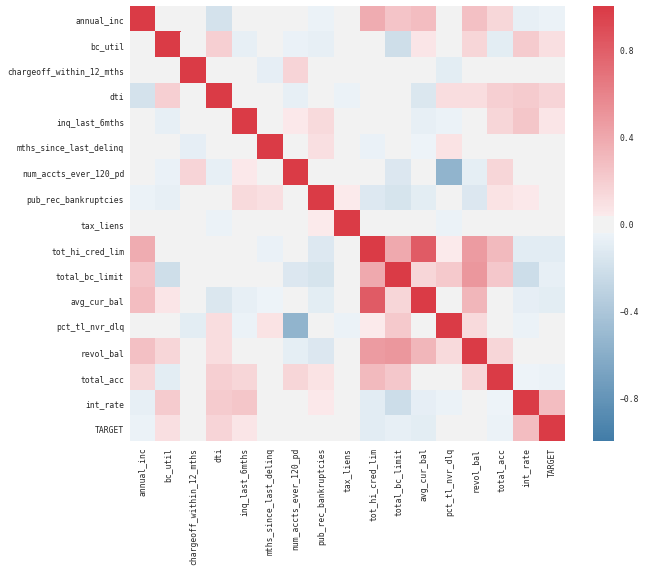

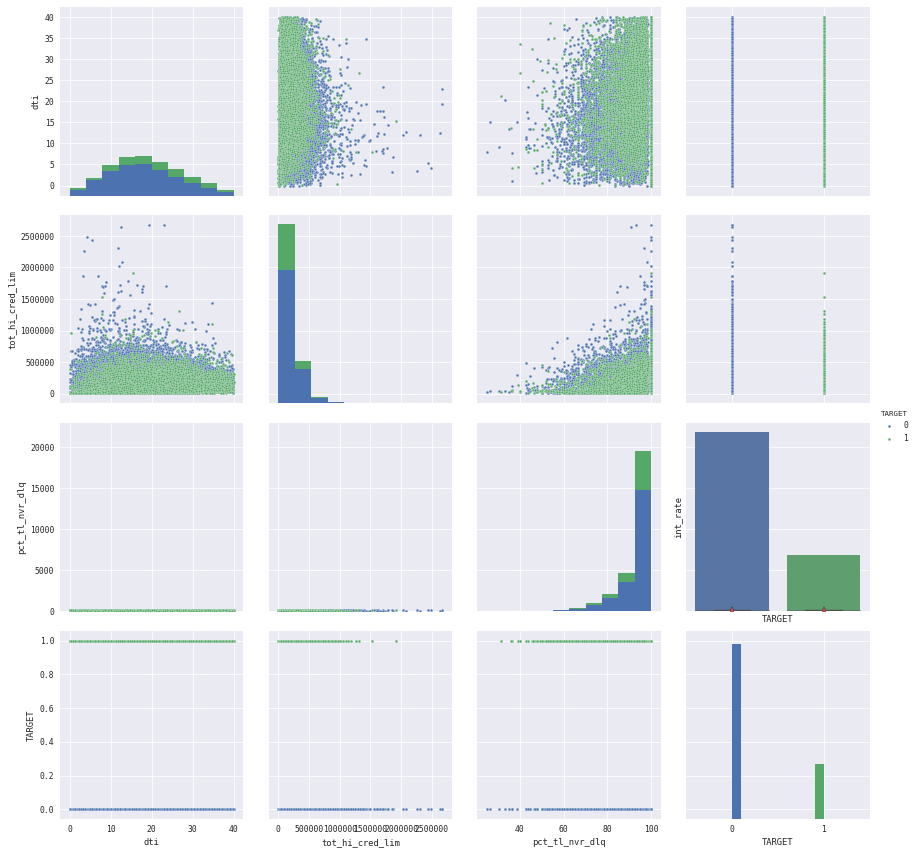

In [2]:
# Box Plot
sns.boxplot(y='bc_util', x='TARGET', data=DF, showmeans=True)
sns.boxplot(y='int_rate', x='TARGET', data=DF, showmeans=True)

In [3]:

# Data Preprocessing ===========================================================
# Split into X and y
y = DF['TARGET']
X = DF.drop('TARGET', 1)

# 1-of-C coding (dummy variable)
X = pd.get_dummies(X)
X = X.drop(['verification_status_Not Verified',
            'home_ownership_MORTGAGE',
            'term_ 36 months'], axis=1)
columns = X.columns.tolist()
print(columns)

# (Stratified) Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=111,
                                                    stratify=y)

# min-max scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

['annual_inc', 'bc_util', 'chargeoff_within_12_mths', 'dti', 'inq_last_6mths', 'mths_since_last_delinq', 'num_accts_ever_120_pd', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bc_limit', 'avg_cur_bal', 'pct_tl_nvr_dlq', 'revol_bal', 'total_acc', 'int_rate', 'verification_status_Source Verified', 'verification_status_Verified', 'home_ownership_OWN', 'home_ownership_RENT', 'term_ 60 months']


In [4]:

# Create Datasets --------------------------------------------------------------
# Original Dataset
X_simple, y_simple = X_train.copy(), y_train.copy()

#del X_train
#del y_train

## UnderSampling
# Random Undersampling
rus = RandomUnderSampler()
X_rus, y_rus= rus.fit_sample(X_simple, y_simple)

# Tomek Links
tl = TomekLinks()
X_tl, y_tl = tl.fit_sample(X_simple, y_simple)

## OverSampling
# SMOTE ('regular')
sm = SMOTE(k_neighbors=5, kind='regular')
X_sm, y_sm = sm.fit_sample(X_simple, y_simple)

## Save Datasets
dataset_names = ['Simple', 'Random Under', 'Tomek', 'SMOTE']
datasets = [(X_simple, y_simple), (X_rus, y_rus), (X_tl, y_tl), (X_sm, y_sm)]

result_fin = pd.DataFrame(np.zeros((len(dataset_names), 4)),
                          index = dataset_names,
                          columns = ["n_obs", "DT", "LR", "RF",])

In [ ]:

# Model Construction ===========================================================
# Model Evaluation -------------------------------------------------------------
for ds_name, ds in zip(dataset_names, datasets):
    X_train, y_train = ds
    
    result_fin.loc[ds_name, 'n_obs'] = X_train.shape[0]

    # Decision Tree
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = geometric_mean_score(y_test, y_pred)
    score = round(score, 3)
    result_fin.loc[ds_name, 'DT'] = score
    
    # Logistic Regression
    logit = Logit(endog=y_train, exog=X_train)
    result = logit.fit(maxiter=1000, disp=0)
    y_pred = logit.predict(params=result.params, exog=X_test).round()
    score = geometric_mean_score(y_test, y_pred)
    score = round(score, 3)
    result_fin.loc[ds_name, 'LR'] = score
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=200)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = geometric_mean_score(y_test, y_pred)
    score = round(score, 3)
    result_fin.loc[ds_name, 'RF'] = score

In [ ]:
# Check effect of each variable ================================================
# Logistic Regression (Coefficients)
logit = Logit(endog=y_rus, exog=X_rus)
result = logit.fit(maxiter=1000, disp=0)
result.summary()

# Get p-values and Coefficients
pval = result.pvalues
coef = result.params

# Get variables with pvalue < 0.05
imp_index = np.where(pval < 0.05)
columns = np.array(columns)

imp_pval = pval[imp_index]
imp_coef = coef[imp_index]
imp_vars = columns[imp_index]

# Plot
plt.figure(figsize=(8,8))
plt.barh(range(len(imp_vars)), imp_coef, color='r')
plt.yticks(range(len(imp_vars)), imp_vars)
plt.show()

In [ ]:
# Random Forest (Feature Importances)
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_rus, y_rus)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices],
         color='r', xerr=std[indices])
plt.yticks(range(X.shape[1]), columns[indices])
plt.show()